In [1]:
import torch
import tqdm
import logger
import numpy as np
import torch.nn as nn
import pickle
import metrics
from skimage import io
from skimage import transform
# from model import FusionNet, DilationCNN, UNet
# from dataset import NucleiDataset, HPADataset, NeuroDataset, HPASingleDataset,get_augmenter
from torch.utils.data import DataLoader
from loss import dice_loss
import imageio


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import torchvision
import torchvision.models as tormodel
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import glob
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

def mkdir_if_missing(save_dir):
    if os.path.exists(save_dir):
        return 1
    else:
        os.makedirs(save_dir)
        return 0

# Dataloader

In [2]:
import torch.utils.data as data
from PIL import Image
import os

class GetLoader(data.Dataset):
    def __init__(self, data_root, img_folder, lab_folder, transform=None):
        self.img_root = os.path.join(data_root,img_folder)
        self.mask_root = os.path.join(data_root,lab_folder)
        self.transform = transform
        
        data_list = os.listdir(self.img_root)
        self.n_data = len(data_list)

        self.img_paths = []
        self.lab_paths = []

        for data in data_list:
            self.img_paths.append(os.path.join(self.img_root,data))
            self.lab_paths.append(os.path.join(self.mask_root,data))

    def __getitem__(self, item):
        img_pth, lab_pth = self.img_paths[item], self.lab_paths[item]
        imgs = Image.open(img_pth).convert('RGB')
        labels = np.asarray(imageio.imread(lab_pth))

        if self.transform is not None:
            imgs = self.transform(imgs)
#             labels = self.transform(labels)
        return imgs, labels

    def __len__(self):
        return self.n_data


In [3]:
DATA_DIR = '/home/zhangj41/HW/group_proj/Organ_cell'
TRAIN_IMG = 'image_train'
TEST_IMG = 'image_test'
TRAIN_MASK = 'mask_train'
TEST_MASK = 'mask_test'

img_transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
])

'''---train loader---'''
DATASET_TRAIN = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TRAIN_IMG, 
    lab_folder=TRAIN_MASK, 
    transform=img_transform_train
)
DATALOADER_TRAIN = torch.utils.data.DataLoader(
    dataset=DATASET_TRAIN,
    batch_size=50,
    shuffle=True)

'''---test loader---'''
DATASET_TEST = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TEST_IMG, 
    lab_folder=TEST_MASK, 
    transform=img_transform_train
)
DATALOADER_TEST = torch.utils.data.DataLoader(
    dataset=DATASET_TEST,
    batch_size=100,
    shuffle=False)

28


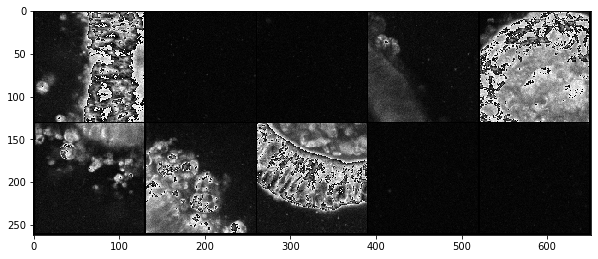

In [4]:
print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
batch_datas, batch_labels = next(iter(DATALOADER_TRAIN)) 
# print(batch_labels)
img = make_grid(batch_datas[0:10], nrow=5, padding=2)

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [5]:
# batch_labels_ = batch_labels.unsqueeze(1)
# print(batch_labels_.size())
# img = make_grid(batch_labels_[0:10], nrow=5, padding=2)
# npimg = img.numpy()
# print(npimg.shape)
# plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray', interpolation='nearest')

In [6]:
batch_label = batch_labels[5]
batch_label.size()

torch.Size([128, 128])

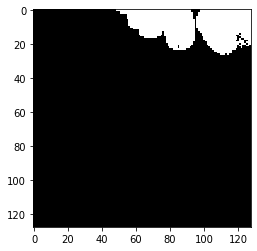

In [7]:
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

# Models

In [8]:
import torch.nn as nn 
import unet_layers as layers


class UNet(nn.Module):
    def __init__(self, num_kernel, kernel_size, dim, target_dim):
        super(UNet, self).__init__()
        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = target_dim

        # encode
        self.encode_1 = layers.DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = layers.DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = layers.DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = layers.DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = layers.UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = layers.UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = layers.UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = layers.UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):
        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)
        pred = self.activate(x)
        return pred

In [9]:
### debug
# batch_datas, batch_labels = next(iter(dataloader_train)) 
# batch_labels.unsqueeze_(1)
# batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()
# unet = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
# unet.cuda()


In [10]:
# loss_function = dice_loss
# pred = unet(batch_datas)
# print(batch_datas.size(), pred.size(), batch_labels.size())
# loss_function(pred, batch_labels)

In [11]:
# print(torch.min(pred),torch.max(pred))
# print(torch.min(batch_labels),torch.max(batch_labels))

# Utils

## Average meter

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Cell segmentation

In [13]:
class CellSeg:
    def __init__(self, unet):
        self.unet = unet
        self.unet.cuda()
        self.optimizer = torch.optim.SGD(self.unet.parameters(),
                                         lr=0.01, momentum=0.9, weight_decay=1e-3)
    
    def scheduler(self, epoch, lr0=1e-2):
        lr = lr0
        if epoch >= 80:
            lr = lr0 * 0.1
        if epoch >= 160:
            lr = lr0 * 0.1

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

            
    def train_batch(self,
                    data_loader,
                    epoch):
        '''--- 1. setup network ---'''
        loss_function = dice_loss
#         total_loss = AverageMeter()
#         total_iou = AverageMeter()
#         total_precision = AverageMeter()
        
        # set train state
        self.unet.train()
        len_dataloader = len(data_loader)
        data_iter = iter(data_loader)

        '''--- 2. train network ---'''
        iters=0
        while iters<len_dataloader-1:
            iters+=1
            input_img, class_label = next(data_iter)
            class_label.unsqueeze_(1)
            input_img, class_label = input_img.cuda(), class_label.cuda()
            batch_size = len(class_label)
            '''forward, compute student ce loss'''
            pred_mask = self.unet(input_img)
            loss = loss_function(pred_mask, class_label)
            
            predictions = pred_mask.clone().squeeze().detach().cpu().numpy()
            gt = class_label.clone().squeeze().detach().cpu().numpy()
            ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
            iou_val = np.mean(ious)
            '''backward teacher generate guided-BP map, detach'''
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if iters%1 == 0:
                print('epoch: {}, [iter {} / all {}], loss:{}, iou:{}'\
                      .format(epoch, iters, len_dataloader, 
                              loss.cpu().data.numpy(),
                              iou_val))
        return loss, iou_val
    
    
    def eval_epoch(self, dataloader):
        cudnn.benchmark = True
        loss_function = dice_loss
        '''---evaluation mode---'''
        self.unet.eval()
        len_dataloader = len(dataloader)
        data_test_iter = iter(dataloader)

        i = 0
        n_total = 0
        n_correct = 0
        total_iou = 0
        total_loss = 0
        total_precision = 0
        counter = 0
#         total_iou = []
        with torch.no_grad():
            while i<len_dataloader:
                # test model using target data
                input_img, class_label = next(data_test_iter)
                class_label.unsqueeze_(1)
                input_img, class_label = input_img.cuda(), class_label.cuda()
                batch_size = len(class_label)

                pred_mask = self.unet(input_img)
                dice_loss_ = loss_function(pred_mask, class_label)
                dice_loss_ = dice_loss_.clone().squeeze().cpu().numpy()
                predictions = pred_mask.clone().squeeze().cpu().numpy()
                gt = class_label.clone().squeeze().cpu().numpy()
                ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
                prec = [metrics.compute_precision(p, g, 0.5) for p,g in zip(predictions, gt)]
#                 total_iou.append(np.mean(ious))
                total_loss += np.sum(dice_loss_)
                total_iou += np.sum(ious)
                total_precision += np.sum(prec)
                counter += batch_size
                i += 1
        iou_avg = total_iou/counter #np.mean(total_iou)
        precision_avg = total_precision/counter
        dice_coeff_avg = 1-total_loss/counter
        print('Normal IOU of the dataset: %f' %(iou_avg))
        print('Normal PREC of the dataset: %f' %(precision_avg))
        print('Normal DICE SCORE of the dataset: %f' %(dice_coeff_avg))
        return iou_avg, precision_avg, dice_coeff_avg
        
        
    def Net_train(self,
                  dl_train,dl_val,
                  n_epochs,
                  save_dir):
        loss_ = []
        iou_val_ = []
        acc_ = []
        for epoch in np.arange(n_epochs):
            # training
            self.scheduler(epoch=epoch)
            loss, iou_val = self.train_batch(data_loader=dl_train,
                                                 epoch=epoch)
            loss_.append(loss)
            iou_val_.append(iou_val)
            # save model
            if epoch>=180:
                file_name = 'unet_epoch'+str(epoch)+'.pth'
                torch.save(self.unet.state_dict(), os.path.join(save_dir,file_name))
            # evaluation
            print('================================================================')
            acc = self.eval_epoch(dataloader=dl_val)
            acc_.append(acc)
            print('================================================================')
        return loss_, iou_val_, acc_

# Main

In [14]:
MODEL_SAVE_PATH = '/home/zhangj41/HW/group_proj/Organ_cell_models'
mkdir_if_missing(MODEL_SAVE_PATH)

solver = CellSeg(unet=UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1))
loss_, iou_val_, acc_ = solver.Net_train(dl_train=DATALOADER_TRAIN,
                                         dl_val=DATALOADER_TEST,
                                         n_epochs=200,
                                         save_dir=MODEL_SAVE_PATH)

epoch: 0, [iter 1 / all 28], loss:0.6117507219314575, iou:0.16576220095157623
epoch: 0, [iter 2 / all 28], loss:0.6108474731445312, iou:0.19062210619449615
epoch: 0, [iter 3 / all 28], loss:0.5382699966430664, iou:0.2382853627204895
epoch: 0, [iter 4 / all 28], loss:0.5743755102157593, iou:0.21841339766979218
epoch: 0, [iter 5 / all 28], loss:0.5415429472923279, iou:0.2086395274847746
epoch: 0, [iter 6 / all 28], loss:0.44458264112472534, iou:0.2534497708082199
epoch: 0, [iter 7 / all 28], loss:0.4308199882507324, iou:0.29391608014702797
epoch: 0, [iter 8 / all 28], loss:0.47251415252685547, iou:0.27828378731384873
epoch: 0, [iter 9 / all 28], loss:0.43046998977661133, iou:0.27140813171863554
epoch: 0, [iter 10 / all 28], loss:0.45657777786254883, iou:0.2610022163391113
epoch: 0, [iter 11 / all 28], loss:0.43696749210357666, iou:0.24723225001245738
epoch: 0, [iter 12 / all 28], loss:0.3544479012489319, iou:0.3336483344435692
epoch: 0, [iter 13 / all 28], loss:0.4031708240509033, iou:0.

epoch: 3, [iter 18 / all 28], loss:0.3681572675704956, iou:0.2877983720041811
epoch: 3, [iter 19 / all 28], loss:0.3654382824897766, iou:0.2695224397815764
epoch: 3, [iter 20 / all 28], loss:0.3466688394546509, iou:0.2783208866417408
epoch: 3, [iter 21 / all 28], loss:0.3365097641944885, iou:0.3052481083571911
epoch: 3, [iter 22 / all 28], loss:0.3471319079399109, iou:0.30646607622504235
epoch: 3, [iter 23 / all 28], loss:0.31280308961868286, iou:0.3534181419201195
epoch: 3, [iter 24 / all 28], loss:0.3655237555503845, iou:0.2914198401942849
epoch: 3, [iter 25 / all 28], loss:0.34239161014556885, iou:0.33702819645404813
epoch: 3, [iter 26 / all 28], loss:0.30679768323898315, iou:0.32760853618383406
epoch: 3, [iter 27 / all 28], loss:0.3324517607688904, iou:0.3304653644189239
Normal accuracy of the dataset: 0.291412
epoch: 4, [iter 1 / all 28], loss:0.3484930396080017, iou:0.2933846075832844
epoch: 4, [iter 2 / all 28], loss:0.3357023000717163, iou:0.2683826744556427
epoch: 4, [iter 3 /

epoch: 7, [iter 6 / all 28], loss:0.3512013554573059, iou:0.2804247014224529
epoch: 7, [iter 7 / all 28], loss:0.33958667516708374, iou:0.2489165896177292
epoch: 7, [iter 8 / all 28], loss:0.3276365399360657, iou:0.28478932277765123
epoch: 7, [iter 9 / all 28], loss:0.30418962240219116, iou:0.29779443874955175
epoch: 7, [iter 10 / all 28], loss:0.3526095747947693, iou:0.21941052216105164
epoch: 7, [iter 11 / all 28], loss:0.3300955891609192, iou:0.30186751499772074
epoch: 7, [iter 12 / all 28], loss:0.30430442094802856, iou:0.2967218139395118
epoch: 7, [iter 13 / all 28], loss:0.3004695773124695, iou:0.34941961131989957
epoch: 7, [iter 14 / all 28], loss:0.30576592683792114, iou:0.2522426794376224
epoch: 7, [iter 15 / all 28], loss:0.3317985534667969, iou:0.26637677296996115
epoch: 7, [iter 16 / all 28], loss:0.3523092269897461, iou:0.2753131534345448
epoch: 7, [iter 17 / all 28], loss:0.35815972089767456, iou:0.29793946698307994
epoch: 7, [iter 18 / all 28], loss:0.322368323802948, io

epoch: 10, [iter 24 / all 28], loss:0.2998303771018982, iou:0.31842642337083815
epoch: 10, [iter 25 / all 28], loss:0.30316638946533203, iou:0.3021084652841091
epoch: 10, [iter 26 / all 28], loss:0.3251774311065674, iou:0.29175010085105896
epoch: 10, [iter 27 / all 28], loss:0.31495600938796997, iou:0.2900515627861023
Normal accuracy of the dataset: 0.307449
epoch: 11, [iter 1 / all 28], loss:0.30545222759246826, iou:0.347714439406991
epoch: 11, [iter 2 / all 28], loss:0.2849116325378418, iou:0.25636321350932123
epoch: 11, [iter 3 / all 28], loss:0.2757800817489624, iou:0.347337072789669
epoch: 11, [iter 4 / all 28], loss:0.2966334819793701, iou:0.3353049534931779
epoch: 11, [iter 5 / all 28], loss:0.3409011960029602, iou:0.3168459339439869
epoch: 11, [iter 6 / all 28], loss:0.3166345953941345, iou:0.3309484393894672
epoch: 11, [iter 7 / all 28], loss:0.2591690421104431, iou:0.4008147346973419
epoch: 11, [iter 8 / all 28], loss:0.341943621635437, iou:0.341693527251482
epoch: 11, [iter 

epoch: 14, [iter 12 / all 28], loss:0.2586210370063782, iou:0.3243862840346992
epoch: 14, [iter 13 / all 28], loss:0.20626431703567505, iou:0.34644939029589294
epoch: 14, [iter 14 / all 28], loss:0.23339122533798218, iou:0.3401038969587535
epoch: 14, [iter 15 / all 28], loss:0.23693394660949707, iou:0.3539279791712761
epoch: 14, [iter 16 / all 28], loss:0.23051446676254272, iou:0.3460843665525317
epoch: 14, [iter 17 / all 28], loss:0.23015397787094116, iou:0.35289629593491556
epoch: 14, [iter 18 / all 28], loss:0.20296454429626465, iou:0.27799552082084117
epoch: 14, [iter 19 / all 28], loss:0.23139631748199463, iou:0.33583617269992827
epoch: 14, [iter 20 / all 28], loss:0.2183496356010437, iou:0.30764893734827636
epoch: 14, [iter 21 / all 28], loss:0.20503520965576172, iou:0.4052652424573898
epoch: 14, [iter 22 / all 28], loss:0.23297619819641113, iou:0.35025677785277365
epoch: 14, [iter 23 / all 28], loss:0.2127528190612793, iou:0.3942610356211662
epoch: 14, [iter 24 / all 28], loss:0

Normal accuracy of the dataset: 0.257923
epoch: 18, [iter 1 / all 28], loss:0.12950259447097778, iou:0.3888918775320053
epoch: 18, [iter 2 / all 28], loss:0.15865665674209595, iou:0.4464846873283386
epoch: 18, [iter 3 / all 28], loss:0.14263564348220825, iou:0.42140486240386965
epoch: 18, [iter 4 / all 28], loss:0.1260780692100525, iou:0.34213984966278077
epoch: 18, [iter 5 / all 28], loss:0.15407580137252808, iou:0.39403275817632677
epoch: 18, [iter 6 / all 28], loss:0.13172882795333862, iou:0.4017562645673752
epoch: 18, [iter 7 / all 28], loss:0.15791839361190796, iou:0.49488865040242674
epoch: 18, [iter 8 / all 28], loss:0.1507604718208313, iou:0.42094134241342546
epoch: 18, [iter 9 / all 28], loss:0.15393579006195068, iou:0.4014670580625534
epoch: 18, [iter 10 / all 28], loss:0.15863287448883057, iou:0.3918257147073746
epoch: 18, [iter 11 / all 28], loss:0.13393551111221313, iou:0.45240391612052916
epoch: 18, [iter 12 / all 28], loss:0.14264631271362305, iou:0.4388095747679472
epoc

epoch: 21, [iter 16 / all 28], loss:0.10478037595748901, iou:0.4324979874491692
epoch: 21, [iter 17 / all 28], loss:0.09690302610397339, iou:0.4750497771427035
epoch: 21, [iter 18 / all 28], loss:0.13974624872207642, iou:0.49765705585479736
epoch: 21, [iter 19 / all 28], loss:0.10991030931472778, iou:0.5463455024547875
epoch: 21, [iter 20 / all 28], loss:0.09914886951446533, iou:0.4924754294753075
epoch: 21, [iter 21 / all 28], loss:0.08898782730102539, iou:0.451490738093853
epoch: 21, [iter 22 / all 28], loss:0.10486304759979248, iou:0.4834778228402138
epoch: 21, [iter 23 / all 28], loss:0.09470683336257935, iou:0.4932048100233078
epoch: 21, [iter 24 / all 28], loss:0.11031430959701538, iou:0.49030510082840917
epoch: 21, [iter 25 / all 28], loss:0.1217355728149414, iou:0.38473554387688635
epoch: 21, [iter 26 / all 28], loss:0.10864537954330444, iou:0.5158259488642216
epoch: 21, [iter 27 / all 28], loss:0.0984986424446106, iou:0.4510961625352502
Normal accuracy of the dataset: 0.324741

epoch: 25, [iter 4 / all 28], loss:0.06557047367095947, iou:0.600153249502182
epoch: 25, [iter 5 / all 28], loss:0.07772558927536011, iou:0.5526597784087062
epoch: 25, [iter 6 / all 28], loss:0.07066565752029419, iou:0.4947583980858326
epoch: 25, [iter 7 / all 28], loss:0.07185626029968262, iou:0.5004112994670868
epoch: 25, [iter 8 / all 28], loss:0.06803977489471436, iou:0.5242655719816685
epoch: 25, [iter 9 / all 28], loss:0.07098513841629028, iou:0.45136446222662924
epoch: 25, [iter 10 / all 28], loss:0.06727343797683716, iou:0.4886753698438406
epoch: 25, [iter 11 / all 28], loss:0.07450449466705322, iou:0.4308355639874935
epoch: 25, [iter 12 / all 28], loss:0.07306480407714844, iou:0.5027616504579783
epoch: 25, [iter 13 / all 28], loss:0.07073706388473511, iou:0.4982801252603531
epoch: 25, [iter 14 / all 28], loss:0.06532686948776245, iou:0.5169749867916107
epoch: 25, [iter 15 / all 28], loss:0.07146579027175903, iou:0.5566268146038056
epoch: 25, [iter 16 / all 28], loss:0.06076711

epoch: 28, [iter 20 / all 28], loss:0.05776268243789673, iou:0.5448907911777496
epoch: 28, [iter 21 / all 28], loss:0.05702102184295654, iou:0.4907544954121113
epoch: 28, [iter 22 / all 28], loss:0.056830525398254395, iou:0.5447147619724274
epoch: 28, [iter 23 / all 28], loss:0.055224478244781494, iou:0.6055487504601479
epoch: 28, [iter 24 / all 28], loss:0.05861341953277588, iou:0.5140908372402191
epoch: 28, [iter 25 / all 28], loss:0.05607956647872925, iou:0.5394408214092254
epoch: 28, [iter 26 / all 28], loss:0.06016898155212402, iou:0.5848850237578154
epoch: 28, [iter 27 / all 28], loss:0.06785285472869873, iou:0.5008176577091217
Normal accuracy of the dataset: 0.405474
epoch: 29, [iter 1 / all 28], loss:0.06992226839065552, iou:0.494655681848526
epoch: 29, [iter 2 / all 28], loss:0.06024599075317383, iou:0.5359804511070252
epoch: 29, [iter 3 / all 28], loss:0.05450540781021118, iou:0.522144059240818
epoch: 29, [iter 4 / all 28], loss:0.05411440134048462, iou:0.5053591024875641
epo

epoch: 32, [iter 8 / all 28], loss:0.0655413269996643, iou:0.5096245747804642
epoch: 32, [iter 9 / all 28], loss:0.051405370235443115, iou:0.5235260912775993
epoch: 32, [iter 10 / all 28], loss:0.052228331565856934, iou:0.5288697600364685
epoch: 32, [iter 11 / all 28], loss:0.05521315336227417, iou:0.6288978517055511
epoch: 32, [iter 12 / all 28], loss:0.0579301118850708, iou:0.6081482458114624
epoch: 32, [iter 13 / all 28], loss:0.05706930160522461, iou:0.5952503395080566
epoch: 32, [iter 14 / all 28], loss:0.0481143593788147, iou:0.5136448235064744
epoch: 32, [iter 15 / all 28], loss:0.050166547298431396, iou:0.5377885687351227
epoch: 32, [iter 16 / all 28], loss:0.05785924196243286, iou:0.44986169278621674
epoch: 32, [iter 17 / all 28], loss:0.04362750053405762, iou:0.5458098220825195
epoch: 32, [iter 18 / all 28], loss:0.051944613456726074, iou:0.37473260939121245
epoch: 32, [iter 19 / all 28], loss:0.05022817850112915, iou:0.5618147492408753
epoch: 32, [iter 20 / all 28], loss:0.0

epoch: 35, [iter 24 / all 28], loss:0.04370296001434326, iou:0.49840761184692384
epoch: 35, [iter 25 / all 28], loss:0.04665189981460571, iou:0.4929198211431503
epoch: 35, [iter 26 / all 28], loss:0.0384940505027771, iou:0.5659470850229263
epoch: 35, [iter 27 / all 28], loss:0.045211195945739746, iou:0.6041345137357712
Normal accuracy of the dataset: 0.423477
epoch: 36, [iter 1 / all 28], loss:0.062177181243896484, iou:0.4847891330718994
epoch: 36, [iter 2 / all 28], loss:0.03613835573196411, iou:0.49789305627346037
epoch: 36, [iter 3 / all 28], loss:0.03846180438995361, iou:0.6082621383666992
epoch: 36, [iter 4 / all 28], loss:0.03988093137741089, iou:0.5679774796962738
epoch: 36, [iter 5 / all 28], loss:0.04765725135803223, iou:0.6590145468711853
epoch: 36, [iter 6 / all 28], loss:0.036399006843566895, iou:0.57804922580719
epoch: 36, [iter 7 / all 28], loss:0.04950922727584839, iou:0.6022594847530126
epoch: 36, [iter 8 / all 28], loss:0.03658837080001831, iou:0.45131341576576234
epoc

epoch: 39, [iter 10 / all 28], loss:0.040926218032836914, iou:0.5086384549736976
epoch: 39, [iter 11 / all 28], loss:0.039569854736328125, iou:0.589159996137023
epoch: 39, [iter 12 / all 28], loss:0.03616207838058472, iou:0.4905285024642944
epoch: 39, [iter 13 / all 28], loss:0.043333590030670166, iou:0.529006975889206
epoch: 39, [iter 14 / all 28], loss:0.036220431327819824, iou:0.5545301771163941
epoch: 39, [iter 15 / all 28], loss:0.03468143939971924, iou:0.5411865484714508
epoch: 39, [iter 16 / all 28], loss:0.03898143768310547, iou:0.6001371908187866
epoch: 39, [iter 17 / all 28], loss:0.04747724533081055, iou:0.5802415883541108
epoch: 39, [iter 18 / all 28], loss:0.043741464614868164, iou:0.5488532114028931
epoch: 39, [iter 19 / all 28], loss:0.037481069564819336, iou:0.5821014860272408
epoch: 39, [iter 20 / all 28], loss:0.037905752658843994, iou:0.5299518555402756
epoch: 39, [iter 21 / all 28], loss:0.03934013843536377, iou:0.5870927619934082
epoch: 39, [iter 22 / all 28], loss

epoch: 42, [iter 26 / all 28], loss:0.03799247741699219, iou:0.47242562532424925
epoch: 42, [iter 27 / all 28], loss:0.03804057836532593, iou:0.5191977845132351
Normal accuracy of the dataset: 0.409749
epoch: 43, [iter 1 / all 28], loss:0.03779047727584839, iou:0.5650621592998505
epoch: 43, [iter 2 / all 28], loss:0.03749054670333862, iou:0.596814033985138
epoch: 43, [iter 3 / all 28], loss:0.03592360019683838, iou:0.5670509481430054
epoch: 43, [iter 4 / all 28], loss:0.03573077917098999, iou:0.6635041737556457
epoch: 43, [iter 5 / all 28], loss:0.03706282377243042, iou:0.5327094781398773
epoch: 43, [iter 6 / all 28], loss:0.03688514232635498, iou:0.6582945054769516
epoch: 43, [iter 7 / all 28], loss:0.03682190179824829, iou:0.6065205907821656
epoch: 43, [iter 8 / all 28], loss:0.035190701484680176, iou:0.5390299445390702
epoch: 43, [iter 9 / all 28], loss:0.03590834140777588, iou:0.4866435095667839
epoch: 43, [iter 10 / all 28], loss:0.03842639923095703, iou:0.5719715884327888
epoch: 

epoch: 46, [iter 14 / all 28], loss:0.03700828552246094, iou:0.5767293614894151
epoch: 46, [iter 15 / all 28], loss:0.03339129686355591, iou:0.566134863961488
epoch: 46, [iter 16 / all 28], loss:0.030622661113739014, iou:0.579858227968216
epoch: 46, [iter 17 / all 28], loss:0.0316583514213562, iou:0.6031914189457893
epoch: 46, [iter 18 / all 28], loss:0.03149622678756714, iou:0.5387322592735291
epoch: 46, [iter 19 / all 28], loss:0.03349846601486206, iou:0.6127613689005375
epoch: 46, [iter 20 / all 28], loss:0.03206026554107666, iou:0.6319139692187309
epoch: 46, [iter 21 / all 28], loss:0.03865456581115723, iou:0.5613561248779297
epoch: 46, [iter 22 / all 28], loss:0.04010432958602905, iou:0.5077062332630158
epoch: 46, [iter 23 / all 28], loss:0.03314828872680664, iou:0.7122153508663177
epoch: 46, [iter 24 / all 28], loss:0.02963864803314209, iou:0.589317911863327
epoch: 46, [iter 25 / all 28], loss:0.032015860080718994, iou:0.6376151752471924
epoch: 46, [iter 26 / all 28], loss:0.0305

epoch: 50, [iter 2 / all 28], loss:0.030578255653381348, iou:0.5877389574050903
epoch: 50, [iter 3 / all 28], loss:0.03047049045562744, iou:0.45161949276924135
epoch: 50, [iter 4 / all 28], loss:0.029357850551605225, iou:0.6120348358154297
epoch: 50, [iter 5 / all 28], loss:0.030691981315612793, iou:0.6056647610664367
epoch: 50, [iter 6 / all 28], loss:0.03344005346298218, iou:0.592040569782257
epoch: 50, [iter 7 / all 28], loss:0.05562138557434082, iou:0.4099742877483368
epoch: 50, [iter 8 / all 28], loss:0.033978402614593506, iou:0.48470327734947205
epoch: 50, [iter 9 / all 28], loss:0.029851973056793213, iou:0.5014729106426239
epoch: 50, [iter 10 / all 28], loss:0.03131520748138428, iou:0.5900019887089729
epoch: 50, [iter 11 / all 28], loss:0.03323769569396973, iou:0.6110677373409271
epoch: 50, [iter 12 / all 28], loss:0.038417279720306396, iou:0.6068238508701325
epoch: 50, [iter 13 / all 28], loss:0.03562057018280029, iou:0.6628715891391039
epoch: 50, [iter 14 / all 28], loss:0.031

epoch: 53, [iter 18 / all 28], loss:0.028030335903167725, iou:0.6514143323898316
epoch: 53, [iter 19 / all 28], loss:0.02826899290084839, iou:0.6457072293758392
epoch: 53, [iter 20 / all 28], loss:0.025915682315826416, iou:0.6486188924312591
epoch: 53, [iter 21 / all 28], loss:0.02589428424835205, iou:0.5942626821994782
epoch: 53, [iter 22 / all 28], loss:0.026822924613952637, iou:0.5498355972766876
epoch: 53, [iter 23 / all 28], loss:0.026247024536132812, iou:0.6769003355503083
epoch: 53, [iter 24 / all 28], loss:0.030682742595672607, iou:0.4465759328007698
epoch: 53, [iter 25 / all 28], loss:0.023802757263183594, iou:0.5087963980436325
epoch: 53, [iter 26 / all 28], loss:0.02673804759979248, iou:0.5370441710948944
epoch: 53, [iter 27 / all 28], loss:0.030869662761688232, iou:0.6454203975200653
Normal accuracy of the dataset: 0.420528
epoch: 54, [iter 1 / all 28], loss:0.02691066265106201, iou:0.6941206347942352
epoch: 54, [iter 2 / all 28], loss:0.03024888038635254, iou:0.65993545055

epoch: 57, [iter 4 / all 28], loss:0.029109716415405273, iou:0.5340084472298622
epoch: 57, [iter 5 / all 28], loss:0.02880573272705078, iou:0.6052605962753296
epoch: 57, [iter 6 / all 28], loss:0.029704689979553223, iou:0.5735067075490952
epoch: 57, [iter 7 / all 28], loss:0.03836697340011597, iou:0.5906549155712127
epoch: 57, [iter 8 / all 28], loss:0.03039705753326416, iou:0.5914465564489365
epoch: 57, [iter 9 / all 28], loss:0.03393137454986572, iou:0.49847343921661375
epoch: 57, [iter 10 / all 28], loss:0.033482134342193604, iou:0.6177157044410706
epoch: 57, [iter 11 / all 28], loss:0.028805792331695557, iou:0.6093062579631805
epoch: 57, [iter 12 / all 28], loss:0.03135937452316284, iou:0.6243164366483689
epoch: 57, [iter 13 / all 28], loss:0.02624046802520752, iou:0.5479977118968964
epoch: 57, [iter 14 / all 28], loss:0.026857733726501465, iou:0.5191064357757569
epoch: 57, [iter 15 / all 28], loss:0.026380479335784912, iou:0.6097493016719818
epoch: 57, [iter 16 / all 28], loss:0.0

epoch: 60, [iter 20 / all 28], loss:0.026693403720855713, iou:0.5008930563926697
epoch: 60, [iter 21 / all 28], loss:0.02519845962524414, iou:0.5915884751081467
epoch: 60, [iter 22 / all 28], loss:0.022040069103240967, iou:0.6326965975761414
epoch: 60, [iter 23 / all 28], loss:0.024031639099121094, iou:0.5974936282634735
epoch: 60, [iter 24 / all 28], loss:0.026440799236297607, iou:0.44891644358634947
epoch: 60, [iter 25 / all 28], loss:0.02332890033721924, iou:0.5541101598739624
epoch: 60, [iter 26 / all 28], loss:0.026180803775787354, iou:0.6372010976076126
epoch: 60, [iter 27 / all 28], loss:0.025217652320861816, iou:0.590499324798584
Normal accuracy of the dataset: 0.441432
epoch: 61, [iter 1 / all 28], loss:0.02329719066619873, iou:0.6008079066872597
epoch: 61, [iter 2 / all 28], loss:0.027315139770507812, iou:0.6606675940752029
epoch: 61, [iter 3 / all 28], loss:0.02634507417678833, iou:0.6283406865596771
epoch: 61, [iter 4 / all 28], loss:0.027727723121643066, iou:0.612945300340

epoch: 64, [iter 6 / all 28], loss:0.024637281894683838, iou:0.5853244304656983
epoch: 64, [iter 7 / all 28], loss:0.02565699815750122, iou:0.5956286838650704
epoch: 64, [iter 8 / all 28], loss:0.024346351623535156, iou:0.5656252437829972
epoch: 64, [iter 9 / all 28], loss:0.024940311908721924, iou:0.482474627494812
epoch: 64, [iter 10 / all 28], loss:0.023658335208892822, iou:0.646553458571434
epoch: 64, [iter 11 / all 28], loss:0.02592933177947998, iou:0.6061802971363067
epoch: 64, [iter 12 / all 28], loss:0.03526473045349121, iou:0.5186808252334595
epoch: 64, [iter 13 / all 28], loss:0.02572333812713623, iou:0.5582776415348053
epoch: 64, [iter 14 / all 28], loss:0.02401876449584961, iou:0.6477125668525696
epoch: 64, [iter 15 / all 28], loss:0.024393856525421143, iou:0.6401999455690384
epoch: 64, [iter 16 / all 28], loss:0.030579090118408203, iou:0.682736454308033
epoch: 64, [iter 17 / all 28], loss:0.021995186805725098, iou:0.5331437230110169
epoch: 64, [iter 18 / all 28], loss:0.02

epoch: 67, [iter 22 / all 28], loss:0.022384047508239746, iou:0.6526958025246858
epoch: 67, [iter 23 / all 28], loss:0.023814499378204346, iou:0.6210628652572632
epoch: 67, [iter 24 / all 28], loss:0.02494567632675171, iou:0.5927044415473938
epoch: 67, [iter 25 / all 28], loss:0.02283930778503418, iou:0.6701143491268158
epoch: 67, [iter 26 / all 28], loss:0.027320563793182373, iou:0.5691173017024994
epoch: 67, [iter 27 / all 28], loss:0.0256272554397583, iou:0.6635176432132721
Normal accuracy of the dataset: 0.433317
epoch: 68, [iter 1 / all 28], loss:0.024918437004089355, iou:0.6292155122756958
epoch: 68, [iter 2 / all 28], loss:0.023734450340270996, iou:0.6952557362616062
epoch: 68, [iter 3 / all 28], loss:0.024846971035003662, iou:0.5883111655712128
epoch: 68, [iter 4 / all 28], loss:0.025901377201080322, iou:0.6584183025360107
epoch: 68, [iter 5 / all 28], loss:0.029395878314971924, iou:0.5629381787776947
epoch: 68, [iter 6 / all 28], loss:0.023262202739715576, iou:0.65245529472827

epoch: 71, [iter 8 / all 28], loss:0.023677527904510498, iou:0.6230076020956039
epoch: 71, [iter 9 / all 28], loss:0.022940337657928467, iou:0.5923508417606353
epoch: 71, [iter 10 / all 28], loss:0.0213661789894104, iou:0.6419202248752117
epoch: 71, [iter 11 / all 28], loss:0.02424532175064087, iou:0.7060873103141785
epoch: 71, [iter 12 / all 28], loss:0.02536797523498535, iou:0.5730885973572731
epoch: 71, [iter 13 / all 28], loss:0.0271148681640625, iou:0.5203599727153778
epoch: 71, [iter 14 / all 28], loss:0.02381974458694458, iou:0.5748705768585205
epoch: 71, [iter 15 / all 28], loss:0.02097034454345703, iou:0.6756036579608917
epoch: 71, [iter 16 / all 28], loss:0.02461063861846924, iou:0.5926237148046494
epoch: 71, [iter 17 / all 28], loss:0.023544788360595703, iou:0.5692772841453553
epoch: 71, [iter 18 / all 28], loss:0.026937901973724365, iou:0.6675993704795837
epoch: 71, [iter 19 / all 28], loss:0.021725237369537354, iou:0.6811023622751236
epoch: 71, [iter 20 / all 28], loss:0.0

epoch: 74, [iter 23 / all 28], loss:0.020663738250732422, iou:0.705457684993744
epoch: 74, [iter 24 / all 28], loss:0.025353729724884033, iou:0.5862133026123046
epoch: 74, [iter 25 / all 28], loss:0.026642441749572754, iou:0.5937486565113068
epoch: 74, [iter 26 / all 28], loss:0.024014651775360107, iou:0.6550375667214393
epoch: 74, [iter 27 / all 28], loss:0.023076534271240234, iou:0.5409210908412934
Normal accuracy of the dataset: 0.436618
epoch: 75, [iter 1 / all 28], loss:0.022549986839294434, iou:0.52273024559021
epoch: 75, [iter 2 / all 28], loss:0.022309184074401855, iou:0.5053628504276275
epoch: 75, [iter 3 / all 28], loss:0.021504580974578857, iou:0.5827069079875946
epoch: 75, [iter 4 / all 28], loss:0.02442556619644165, iou:0.581103321313858
epoch: 75, [iter 5 / all 28], loss:0.02654421329498291, iou:0.7159154224395752
epoch: 75, [iter 6 / all 28], loss:0.02240508794784546, iou:0.691972267627716
epoch: 75, [iter 7 / all 28], loss:0.020625174045562744, iou:0.5614603328704834
ep

epoch: 78, [iter 9 / all 28], loss:0.019839704036712646, iou:0.677015346288681
epoch: 78, [iter 10 / all 28], loss:0.019267797470092773, iou:0.6774640226364136
epoch: 78, [iter 11 / all 28], loss:0.021194756031036377, iou:0.5633744192123413
epoch: 78, [iter 12 / all 28], loss:0.020943284034729004, iou:0.5997513782978058
epoch: 78, [iter 13 / all 28], loss:0.0192563533782959, iou:0.5651897859573364
epoch: 78, [iter 14 / all 28], loss:0.020063400268554688, iou:0.6192452621459961
epoch: 78, [iter 15 / all 28], loss:0.023218274116516113, iou:0.5429907743632794
epoch: 78, [iter 16 / all 28], loss:0.021509826183319092, iou:0.5798894241452217
epoch: 78, [iter 17 / all 28], loss:0.02369588613510132, iou:0.6684992969036102
epoch: 78, [iter 18 / all 28], loss:0.023114025592803955, iou:0.6717805671691894
epoch: 78, [iter 19 / all 28], loss:0.021131396293640137, iou:0.5712462055683136
epoch: 78, [iter 20 / all 28], loss:0.0192410945892334, iou:0.6381011267006397
epoch: 78, [iter 21 / all 28], loss

epoch: 81, [iter 24 / all 28], loss:0.018135368824005127, iou:0.45312841415405275
epoch: 81, [iter 25 / all 28], loss:0.01722097396850586, iou:0.6871800518035889
epoch: 81, [iter 26 / all 28], loss:0.020861327648162842, iou:0.5670932748913765
epoch: 81, [iter 27 / all 28], loss:0.02442646026611328, iou:0.5938079476356506
Normal accuracy of the dataset: 0.442500
epoch: 82, [iter 1 / all 28], loss:0.019685208797454834, iou:0.7180127799510956
epoch: 82, [iter 2 / all 28], loss:0.01849573850631714, iou:0.628800139427185
epoch: 82, [iter 3 / all 28], loss:0.020958662033081055, iou:0.5902582541108131
epoch: 82, [iter 4 / all 28], loss:0.022727251052856445, iou:0.5915155923366546
epoch: 82, [iter 5 / all 28], loss:0.01934075355529785, iou:0.6581489443778992
epoch: 82, [iter 6 / all 28], loss:0.01824188232421875, iou:0.5687785094976425
epoch: 82, [iter 7 / all 28], loss:0.018450498580932617, iou:0.632761862874031
epoch: 82, [iter 8 / all 28], loss:0.015827417373657227, iou:0.6087688148021698
e

epoch: 85, [iter 10 / all 28], loss:0.018098413944244385, iou:0.6236203598976136
epoch: 85, [iter 11 / all 28], loss:0.016055524349212646, iou:0.6132873833179474
epoch: 85, [iter 12 / all 28], loss:0.01805436611175537, iou:0.6222933056950569
epoch: 85, [iter 13 / all 28], loss:0.019931554794311523, iou:0.5552181100845337
epoch: 85, [iter 14 / all 28], loss:0.019712984561920166, iou:0.5848456650972367
epoch: 85, [iter 15 / all 28], loss:0.01811516284942627, iou:0.645946455001831
epoch: 85, [iter 16 / all 28], loss:0.017756879329681396, iou:0.6182173240184784
epoch: 85, [iter 17 / all 28], loss:0.016582489013671875, iou:0.6261829388141632
epoch: 85, [iter 18 / all 28], loss:0.02021092176437378, iou:0.5947306954860687
epoch: 85, [iter 19 / all 28], loss:0.01879662275314331, iou:0.6938465440273285
epoch: 85, [iter 20 / all 28], loss:0.020523250102996826, iou:0.6850197905302048
epoch: 85, [iter 21 / all 28], loss:0.01823335886001587, iou:0.5798340260982513
epoch: 85, [iter 22 / all 28], los

epoch: 88, [iter 25 / all 28], loss:0.01733839511871338, iou:0.5378666710853577
epoch: 88, [iter 26 / all 28], loss:0.01790487766265869, iou:0.572864203453064
epoch: 88, [iter 27 / all 28], loss:0.016184568405151367, iou:0.5807638967037201
Normal accuracy of the dataset: 0.443393
epoch: 89, [iter 1 / all 28], loss:0.01825493574142456, iou:0.6230712127685547
epoch: 89, [iter 2 / all 28], loss:0.021161973476409912, iou:0.46522766470909116
epoch: 89, [iter 3 / all 28], loss:0.020943760871887207, iou:0.5431361627578736
epoch: 89, [iter 4 / all 28], loss:0.015605270862579346, iou:0.5329874575138092
epoch: 89, [iter 5 / all 28], loss:0.01857614517211914, iou:0.6423831129074097
epoch: 89, [iter 6 / all 28], loss:0.019575178623199463, iou:0.5845188543200492
epoch: 89, [iter 7 / all 28], loss:0.01680976152420044, iou:0.6278041052818298
epoch: 89, [iter 8 / all 28], loss:0.01971149444580078, iou:0.5864869058132172
epoch: 89, [iter 9 / all 28], loss:0.01866978406906128, iou:0.6245874774456024
epo

epoch: 92, [iter 12 / all 28], loss:0.017628729343414307, iou:0.6374600327014923
epoch: 92, [iter 13 / all 28], loss:0.017694592475891113, iou:0.7253903269767761
epoch: 92, [iter 14 / all 28], loss:0.01666879653930664, iou:0.5725228157639504
epoch: 92, [iter 15 / all 28], loss:0.022723257541656494, iou:0.48101213812828064
epoch: 92, [iter 16 / all 28], loss:0.016691148281097412, iou:0.5800367003679275
epoch: 92, [iter 17 / all 28], loss:0.017098724842071533, iou:0.6326833587884902
epoch: 92, [iter 18 / all 28], loss:0.02058696746826172, iou:0.6936439955234528
epoch: 92, [iter 19 / all 28], loss:0.019308865070343018, iou:0.5792200410366058
epoch: 92, [iter 20 / all 28], loss:0.016507625579833984, iou:0.6680357122421264
epoch: 92, [iter 21 / all 28], loss:0.017793118953704834, iou:0.5658846321702004
epoch: 92, [iter 22 / all 28], loss:0.01687312126159668, iou:0.6788429713249207
epoch: 92, [iter 23 / all 28], loss:0.015737533569335938, iou:0.5161181998252868
epoch: 92, [iter 24 / all 28],

epoch: 95, [iter 27 / all 28], loss:0.01862257719039917, iou:0.5890706753730774
Normal accuracy of the dataset: 0.444786
epoch: 96, [iter 1 / all 28], loss:0.016699790954589844, iou:0.6298709642887116
epoch: 96, [iter 2 / all 28], loss:0.01791900396347046, iou:0.6988787484169007
epoch: 96, [iter 3 / all 28], loss:0.015380918979644775, iou:0.6072116911411285
epoch: 96, [iter 4 / all 28], loss:0.016374826431274414, iou:0.6677964997291564
epoch: 96, [iter 5 / all 28], loss:0.018241524696350098, iou:0.5105487620830536
epoch: 96, [iter 6 / all 28], loss:0.01989203691482544, iou:0.4342912209033966
epoch: 96, [iter 7 / all 28], loss:0.0180971622467041, iou:0.46998217940330506
epoch: 96, [iter 8 / all 28], loss:0.01654529571533203, iou:0.639866577386856
epoch: 96, [iter 9 / all 28], loss:0.017795920372009277, iou:0.6295964562892914
epoch: 96, [iter 10 / all 28], loss:0.0175173282623291, iou:0.5695128285884857
epoch: 96, [iter 11 / all 28], loss:0.0185660719871521, iou:0.5682027366757393
epoch:

epoch: 99, [iter 13 / all 28], loss:0.02103334665298462, iou:0.6142588400840759
epoch: 99, [iter 14 / all 28], loss:0.016737520694732666, iou:0.58642538189888
epoch: 99, [iter 15 / all 28], loss:0.018503248691558838, iou:0.5914687436819076
epoch: 99, [iter 16 / all 28], loss:0.018447458744049072, iou:0.5777552092075348
epoch: 99, [iter 17 / all 28], loss:0.018481791019439697, iou:0.5668800067901612
epoch: 99, [iter 18 / all 28], loss:0.014365553855895996, iou:0.5799137276411056
epoch: 99, [iter 19 / all 28], loss:0.015446126461029053, iou:0.6039114797115326
epoch: 99, [iter 20 / all 28], loss:0.01661628484725952, iou:0.6114311575889587
epoch: 99, [iter 21 / all 28], loss:0.016785025596618652, iou:0.6297524404525757
epoch: 99, [iter 22 / all 28], loss:0.0180320143699646, iou:0.6804851211607457
epoch: 99, [iter 23 / all 28], loss:0.01715254783630371, iou:0.6067643630504608
epoch: 99, [iter 24 / all 28], loss:0.016846120357513428, iou:0.6677049231529236
epoch: 99, [iter 25 / all 28], loss

epoch: 102, [iter 27 / all 28], loss:0.014163970947265625, iou:0.5751310586929321
Normal accuracy of the dataset: 0.444659
epoch: 103, [iter 1 / all 28], loss:0.01888418197631836, iou:0.6240579378604889
epoch: 103, [iter 2 / all 28], loss:0.015670478343963623, iou:0.613799260854721
epoch: 103, [iter 3 / all 28], loss:0.015190720558166504, iou:0.7072363829612732
epoch: 103, [iter 4 / all 28], loss:0.02145439386367798, iou:0.6595441901683807
epoch: 103, [iter 5 / all 28], loss:0.016051054000854492, iou:0.6018367463350296
epoch: 103, [iter 6 / all 28], loss:0.019404888153076172, iou:0.6785886907577514
epoch: 103, [iter 7 / all 28], loss:0.019157707691192627, iou:0.5906862300634385
epoch: 103, [iter 8 / all 28], loss:0.017754018306732178, iou:0.5335123383998871
epoch: 103, [iter 9 / all 28], loss:0.02225935459136963, iou:0.4868673288822174
epoch: 103, [iter 10 / all 28], loss:0.01654052734375, iou:0.5506441342830658
epoch: 103, [iter 11 / all 28], loss:0.01653653383255005, iou:0.6849893450

epoch: 106, [iter 12 / all 28], loss:0.018311500549316406, iou:0.5414519500732422
epoch: 106, [iter 13 / all 28], loss:0.015699028968811035, iou:0.6201292073726654
epoch: 106, [iter 14 / all 28], loss:0.021743357181549072, iou:0.7025963950157166
epoch: 106, [iter 15 / all 28], loss:0.018942058086395264, iou:0.5673850297927856
epoch: 106, [iter 16 / all 28], loss:0.020097315311431885, iou:0.5289521002769471
epoch: 106, [iter 17 / all 28], loss:0.017298579216003418, iou:0.6919930481910705
epoch: 106, [iter 18 / all 28], loss:0.017271876335144043, iou:0.7029204475879669
epoch: 106, [iter 19 / all 28], loss:0.01717853546142578, iou:0.5897472953796387
epoch: 106, [iter 20 / all 28], loss:0.01632934808731079, iou:0.6138589704036712
epoch: 106, [iter 21 / all 28], loss:0.01748967170715332, iou:0.5680236458778382
epoch: 106, [iter 22 / all 28], loss:0.017053604125976562, iou:0.6943707621097565
epoch: 106, [iter 23 / all 28], loss:0.018803536891937256, iou:0.6477726757526397
epoch: 106, [iter 2

epoch: 109, [iter 26 / all 28], loss:0.015344381332397461, iou:0.6049860072135925
epoch: 109, [iter 27 / all 28], loss:0.01711750030517578, iou:0.5356541848182679
Normal accuracy of the dataset: 0.442841
epoch: 110, [iter 1 / all 28], loss:0.017648518085479736, iou:0.6801511466503143
epoch: 110, [iter 2 / all 28], loss:0.01780116558074951, iou:0.6773481428623199
epoch: 110, [iter 3 / all 28], loss:0.01851564645767212, iou:0.5368355959653854
epoch: 110, [iter 4 / all 28], loss:0.017338454723358154, iou:0.6038626444339752
epoch: 110, [iter 5 / all 28], loss:0.01773291826248169, iou:0.6977256870269776
epoch: 110, [iter 6 / all 28], loss:0.018712282180786133, iou:0.6212372601032257
epoch: 110, [iter 7 / all 28], loss:0.01905059814453125, iou:0.5606020486354828
epoch: 110, [iter 8 / all 28], loss:0.016311228275299072, iou:0.5886236333847046
epoch: 110, [iter 9 / all 28], loss:0.01589912176132202, iou:0.50300078779459
epoch: 110, [iter 10 / all 28], loss:0.01595824956893921, iou:0.6123290705

epoch: 113, [iter 11 / all 28], loss:0.01777571439743042, iou:0.5089216923713684
epoch: 113, [iter 12 / all 28], loss:0.01731252670288086, iou:0.5746414268016815
epoch: 113, [iter 13 / all 28], loss:0.016844630241394043, iou:0.6721420323848725
epoch: 113, [iter 14 / all 28], loss:0.01844555139541626, iou:0.652001251578331
epoch: 113, [iter 15 / all 28], loss:0.017732560634613037, iou:0.6355561369657516
epoch: 113, [iter 16 / all 28], loss:0.018520236015319824, iou:0.6203971076011657
epoch: 113, [iter 17 / all 28], loss:0.01866215467453003, iou:0.6967100417613983
epoch: 113, [iter 18 / all 28], loss:0.01600545644760132, iou:0.67147136926651
epoch: 113, [iter 19 / all 28], loss:0.016096115112304688, iou:0.6251830545812845
epoch: 113, [iter 20 / all 28], loss:0.01773357391357422, iou:0.5105006283521653
epoch: 113, [iter 21 / all 28], loss:0.015917301177978516, iou:0.5141119742393494
epoch: 113, [iter 22 / all 28], loss:0.01711869239807129, iou:0.557375956773758
epoch: 113, [iter 23 / all 

epoch: 116, [iter 25 / all 28], loss:0.01648765802383423, iou:0.5480516743659973
epoch: 116, [iter 26 / all 28], loss:0.0184401273727417, iou:0.6042730289697648
epoch: 116, [iter 27 / all 28], loss:0.022150874137878418, iou:0.5645453572273255
Normal accuracy of the dataset: 0.443484
epoch: 117, [iter 1 / all 28], loss:0.017141282558441162, iou:0.7323590713739395
epoch: 117, [iter 2 / all 28], loss:0.016527533531188965, iou:0.5724657511711121
epoch: 117, [iter 3 / all 28], loss:0.01799607276916504, iou:0.656759786605835
epoch: 117, [iter 4 / all 28], loss:0.016329944133758545, iou:0.5947216284275055
epoch: 117, [iter 5 / all 28], loss:0.016212165355682373, iou:0.552972594499588
epoch: 117, [iter 6 / all 28], loss:0.016219794750213623, iou:0.6375182843208314
epoch: 117, [iter 7 / all 28], loss:0.020044803619384766, iou:0.6574449098110199
epoch: 117, [iter 8 / all 28], loss:0.01654958724975586, iou:0.6649834230542183
epoch: 117, [iter 9 / all 28], loss:0.016297876834869385, iou:0.61960637

epoch: 120, [iter 10 / all 28], loss:0.014561831951141357, iou:0.6115979766845703
epoch: 120, [iter 11 / all 28], loss:0.017293453216552734, iou:0.57840705037117
epoch: 120, [iter 12 / all 28], loss:0.01701951026916504, iou:0.7005957102775574
epoch: 120, [iter 13 / all 28], loss:0.017453372478485107, iou:0.6862639486789703
epoch: 120, [iter 14 / all 28], loss:0.018577158451080322, iou:0.7017571353912353
epoch: 120, [iter 15 / all 28], loss:0.021938800811767578, iou:0.5056636369228363
epoch: 120, [iter 16 / all 28], loss:0.016830623149871826, iou:0.6255590987205505
epoch: 120, [iter 17 / all 28], loss:0.01646137237548828, iou:0.6493922567367554
epoch: 120, [iter 18 / all 28], loss:0.017083466053009033, iou:0.6833824288845062
epoch: 120, [iter 19 / all 28], loss:0.018414616584777832, iou:0.5868696880340576
epoch: 120, [iter 20 / all 28], loss:0.01974010467529297, iou:0.6402802589535713
epoch: 120, [iter 21 / all 28], loss:0.017716407775878906, iou:0.7038420687615872
epoch: 120, [iter 22 

epoch: 123, [iter 24 / all 28], loss:0.01713627576828003, iou:0.5110490608215332
epoch: 123, [iter 25 / all 28], loss:0.01581341028213501, iou:0.554123826622963
epoch: 123, [iter 26 / all 28], loss:0.015762507915496826, iou:0.5932022607326508
epoch: 123, [iter 27 / all 28], loss:0.017121195793151855, iou:0.6218061816692352
Normal accuracy of the dataset: 0.442894
epoch: 124, [iter 1 / all 28], loss:0.015869319438934326, iou:0.5783036817610264
epoch: 124, [iter 2 / all 28], loss:0.016845285892486572, iou:0.5045094382762909
epoch: 124, [iter 3 / all 28], loss:0.02363353967666626, iou:0.532169314622879
epoch: 124, [iter 4 / all 28], loss:0.01592928171157837, iou:0.6958621972799302
epoch: 124, [iter 5 / all 28], loss:0.0160943865776062, iou:0.5727776336669922
epoch: 124, [iter 6 / all 28], loss:0.017269253730773926, iou:0.5711795628070832
epoch: 124, [iter 7 / all 28], loss:0.015727996826171875, iou:0.6091008234024048
epoch: 124, [iter 8 / all 28], loss:0.01601964235305786, iou:0.573604390

epoch: 127, [iter 10 / all 28], loss:0.015949606895446777, iou:0.6109557187557221
epoch: 127, [iter 11 / all 28], loss:0.017241835594177246, iou:0.6864024031162262
epoch: 127, [iter 12 / all 28], loss:0.017846763134002686, iou:0.6096358847618103
epoch: 127, [iter 13 / all 28], loss:0.01609116792678833, iou:0.6093172001838684
epoch: 127, [iter 14 / all 28], loss:0.018362462520599365, iou:0.5765745955705642
epoch: 127, [iter 15 / all 28], loss:0.016446948051452637, iou:0.6110608094930648
epoch: 127, [iter 16 / all 28], loss:0.015424668788909912, iou:0.6079382336139679
epoch: 127, [iter 17 / all 28], loss:0.015712857246398926, iou:0.6427009928226471
epoch: 127, [iter 18 / all 28], loss:0.01666182279586792, iou:0.6433707070350647
epoch: 127, [iter 19 / all 28], loss:0.017517685890197754, iou:0.6012245005369187
epoch: 127, [iter 20 / all 28], loss:0.01535111665725708, iou:0.6231366777420044
epoch: 127, [iter 21 / all 28], loss:0.016443192958831787, iou:0.5632994604110718
epoch: 127, [iter 2

epoch: 130, [iter 24 / all 28], loss:0.015620529651641846, iou:0.7082453607022763
epoch: 130, [iter 25 / all 28], loss:0.01582634449005127, iou:0.6497838234901429
epoch: 130, [iter 26 / all 28], loss:0.014711081981658936, iou:0.579044000506401
epoch: 130, [iter 27 / all 28], loss:0.015648305416107178, iou:0.5883779013156891
Normal accuracy of the dataset: 0.439600
epoch: 131, [iter 1 / all 28], loss:0.015547335147857666, iou:0.6453688041865826
epoch: 131, [iter 2 / all 28], loss:0.017541706562042236, iou:0.6269014120101929
epoch: 131, [iter 3 / all 28], loss:0.016263604164123535, iou:0.7076583743095398
epoch: 131, [iter 4 / all 28], loss:0.014952361583709717, iou:0.6349606108665466
epoch: 131, [iter 5 / all 28], loss:0.01870661973953247, iou:0.5678495311737061
epoch: 131, [iter 6 / all 28], loss:0.014891505241394043, iou:0.554471583366394
epoch: 131, [iter 7 / all 28], loss:0.016130447387695312, iou:0.5894175720214844
epoch: 131, [iter 8 / all 28], loss:0.015850841999053955, iou:0.6047

epoch: 134, [iter 10 / all 28], loss:0.016078293323516846, iou:0.5475635254383087
epoch: 134, [iter 11 / all 28], loss:0.01648998260498047, iou:0.6873606735467911
epoch: 134, [iter 12 / all 28], loss:0.01670968532562256, iou:0.6385421314835549
epoch: 134, [iter 13 / all 28], loss:0.019716203212738037, iou:0.5921658301353454
epoch: 134, [iter 14 / all 28], loss:0.017824947834014893, iou:0.6800576817989349
epoch: 134, [iter 15 / all 28], loss:0.01435840129852295, iou:0.5187395453453064
epoch: 134, [iter 16 / all 28], loss:0.015796780586242676, iou:0.5910866665840149
epoch: 134, [iter 17 / all 28], loss:0.0171317458152771, iou:0.6103464555740357
epoch: 134, [iter 18 / all 28], loss:0.02213042974472046, iou:0.5429836857318878
epoch: 134, [iter 19 / all 28], loss:0.017640113830566406, iou:0.6204758048057556
epoch: 134, [iter 20 / all 28], loss:0.016936659812927246, iou:0.5917406034469604
epoch: 134, [iter 21 / all 28], loss:0.016675949096679688, iou:0.4966578412055969
epoch: 134, [iter 22 /

epoch: 137, [iter 24 / all 28], loss:0.016130387783050537, iou:0.5709833109378815
epoch: 137, [iter 25 / all 28], loss:0.01536184549331665, iou:0.5807557064294815
epoch: 137, [iter 26 / all 28], loss:0.017204880714416504, iou:0.5674203097820282
epoch: 137, [iter 27 / all 28], loss:0.016888737678527832, iou:0.6090619909763336
Normal accuracy of the dataset: 0.445575
epoch: 138, [iter 1 / all 28], loss:0.01856374740600586, iou:0.5789581590890884
epoch: 138, [iter 2 / all 28], loss:0.014881014823913574, iou:0.5550432562828064
epoch: 138, [iter 3 / all 28], loss:0.015869081020355225, iou:0.6495591068267822
epoch: 138, [iter 4 / all 28], loss:0.01580524444580078, iou:0.5519374871253967
epoch: 138, [iter 5 / all 28], loss:0.015955328941345215, iou:0.5842921984195709
epoch: 138, [iter 6 / all 28], loss:0.016923367977142334, iou:0.6170055890083312
epoch: 138, [iter 7 / all 28], loss:0.015418946743011475, iou:0.6482889068126678
epoch: 138, [iter 8 / all 28], loss:0.020108401775360107, iou:0.550

epoch: 141, [iter 10 / all 28], loss:0.016463160514831543, iou:0.6286477684974671
epoch: 141, [iter 11 / all 28], loss:0.015950024127960205, iou:0.5343470111489296
epoch: 141, [iter 12 / all 28], loss:0.017218708992004395, iou:0.5510797929763794
epoch: 141, [iter 13 / all 28], loss:0.019036710262298584, iou:0.625154293179512
epoch: 141, [iter 14 / all 28], loss:0.01800227165222168, iou:0.6319276708364486
epoch: 141, [iter 15 / all 28], loss:0.014627456665039062, iou:0.6524484074115753
epoch: 141, [iter 16 / all 28], loss:0.01628333330154419, iou:0.6297394287586212
epoch: 141, [iter 17 / all 28], loss:0.022002995014190674, iou:0.544371234178543
epoch: 141, [iter 18 / all 28], loss:0.01710110902786255, iou:0.6803557682037353
epoch: 141, [iter 19 / all 28], loss:0.01615828275680542, iou:0.5481834042072297
epoch: 141, [iter 20 / all 28], loss:0.01719146966934204, iou:0.6107923537492752
epoch: 141, [iter 21 / all 28], loss:0.016705811023712158, iou:0.6396150612831115
epoch: 141, [iter 22 / 

epoch: 144, [iter 24 / all 28], loss:0.018103420734405518, iou:0.7346938788890839
epoch: 144, [iter 25 / all 28], loss:0.015954256057739258, iou:0.6257243633270264
epoch: 144, [iter 26 / all 28], loss:0.016805946826934814, iou:0.6031907087564469
epoch: 144, [iter 27 / all 28], loss:0.016867399215698242, iou:0.5539828753471374
Normal accuracy of the dataset: 0.442278
epoch: 145, [iter 1 / all 28], loss:0.015238583087921143, iou:0.6315272009372711
epoch: 145, [iter 2 / all 28], loss:0.0159914493560791, iou:0.6943706619739533
epoch: 145, [iter 3 / all 28], loss:0.016620397567749023, iou:0.6199737513065338
epoch: 145, [iter 4 / all 28], loss:0.015045166015625, iou:0.6499013996124268
epoch: 145, [iter 5 / all 28], loss:0.01790010929107666, iou:0.4213537275791168
epoch: 145, [iter 6 / all 28], loss:0.017530977725982666, iou:0.642374187707901
epoch: 145, [iter 7 / all 28], loss:0.016349375247955322, iou:0.6408202791213989
epoch: 145, [iter 8 / all 28], loss:0.015172600746154785, iou:0.6275172

epoch: 148, [iter 10 / all 28], loss:0.01521146297454834, iou:0.591929076910019
epoch: 148, [iter 11 / all 28], loss:0.01644289493560791, iou:0.5534272006154061
epoch: 148, [iter 12 / all 28], loss:0.016084671020507812, iou:0.6762671530246734
epoch: 148, [iter 13 / all 28], loss:0.01739722490310669, iou:0.6290397429466248
epoch: 148, [iter 14 / all 28], loss:0.01716291904449463, iou:0.6131814396381379
epoch: 148, [iter 15 / all 28], loss:0.01635950803756714, iou:0.7016203713417053
epoch: 148, [iter 16 / all 28], loss:0.01504594087600708, iou:0.6073907148838044
epoch: 148, [iter 17 / all 28], loss:0.016239583492279053, iou:0.6888882690668106
epoch: 148, [iter 18 / all 28], loss:0.02042222023010254, iou:0.47799756824970246
epoch: 148, [iter 19 / all 28], loss:0.016389548778533936, iou:0.572865903377533
epoch: 148, [iter 20 / all 28], loss:0.016252756118774414, iou:0.7384477400779724
epoch: 148, [iter 21 / all 28], loss:0.017302632331848145, iou:0.5535721904039383
epoch: 148, [iter 22 / a

epoch: 151, [iter 24 / all 28], loss:0.015947937965393066, iou:0.6233017706871032
epoch: 151, [iter 25 / all 28], loss:0.015387475490570068, iou:0.6033375191688538
epoch: 151, [iter 26 / all 28], loss:0.01665365695953369, iou:0.6500152659416198
epoch: 151, [iter 27 / all 28], loss:0.014213204383850098, iou:0.5558891665935516
Normal accuracy of the dataset: 0.443836
epoch: 152, [iter 1 / all 28], loss:0.017739534378051758, iou:0.6145657742023468
epoch: 152, [iter 2 / all 28], loss:0.015601575374603271, iou:0.630479918718338
epoch: 152, [iter 3 / all 28], loss:0.015947580337524414, iou:0.6643093094229698
epoch: 152, [iter 4 / all 28], loss:0.015652239322662354, iou:0.589867080450058
epoch: 152, [iter 5 / all 28], loss:0.014941513538360596, iou:0.6022756254673004
epoch: 152, [iter 6 / all 28], loss:0.015954136848449707, iou:0.6881986308097839
epoch: 152, [iter 7 / all 28], loss:0.01598644256591797, iou:0.724797842502594
epoch: 152, [iter 8 / all 28], loss:0.018858671188354492, iou:0.57099

epoch: 155, [iter 10 / all 28], loss:0.014446675777435303, iou:0.572628732919693
epoch: 155, [iter 11 / all 28], loss:0.015076220035552979, iou:0.604764952659607
epoch: 155, [iter 12 / all 28], loss:0.014944791793823242, iou:0.5572076499462127
epoch: 155, [iter 13 / all 28], loss:0.016200125217437744, iou:0.6846064591407776
epoch: 155, [iter 14 / all 28], loss:0.017770230770111084, iou:0.5278210544586182
epoch: 155, [iter 15 / all 28], loss:0.015389084815979004, iou:0.6493441998958588
epoch: 155, [iter 16 / all 28], loss:0.01680999994277954, iou:0.6464376664161682
epoch: 155, [iter 17 / all 28], loss:0.015531182289123535, iou:0.6172900593280792
epoch: 155, [iter 18 / all 28], loss:0.013783633708953857, iou:0.6343267560005188
epoch: 155, [iter 19 / all 28], loss:0.01593571901321411, iou:0.6112691915035248
epoch: 155, [iter 20 / all 28], loss:0.0190352201461792, iou:0.5651804375648498
epoch: 155, [iter 21 / all 28], loss:0.015606701374053955, iou:0.5726887571811676
epoch: 155, [iter 22 /

epoch: 158, [iter 24 / all 28], loss:0.019252479076385498, iou:0.7113979625701904
epoch: 158, [iter 25 / all 28], loss:0.01916801929473877, iou:0.5689606654644013
epoch: 158, [iter 26 / all 28], loss:0.015010058879852295, iou:0.49697556138038634
epoch: 158, [iter 27 / all 28], loss:0.019571661949157715, iou:0.6529015100002289
Normal accuracy of the dataset: 0.445625
epoch: 159, [iter 1 / all 28], loss:0.0153733491897583, iou:0.5475680434703827
epoch: 159, [iter 2 / all 28], loss:0.018206357955932617, iou:0.6379149258136749
epoch: 159, [iter 3 / all 28], loss:0.01562601327896118, iou:0.6496074211597442
epoch: 159, [iter 4 / all 28], loss:0.01600468158721924, iou:0.6296048760414124
epoch: 159, [iter 5 / all 28], loss:0.016548454761505127, iou:0.6889261877536774
epoch: 159, [iter 6 / all 28], loss:0.014839529991149902, iou:0.6162526571750641
epoch: 159, [iter 7 / all 28], loss:0.021296381950378418, iou:0.6157621347904205
epoch: 159, [iter 8 / all 28], loss:0.01609623432159424, iou:0.61180

epoch: 162, [iter 10 / all 28], loss:0.018056929111480713, iou:0.5648210048675537
epoch: 162, [iter 11 / all 28], loss:0.017577946186065674, iou:0.6797777092456818
epoch: 162, [iter 12 / all 28], loss:0.014742910861968994, iou:0.5539182937145233
epoch: 162, [iter 13 / all 28], loss:0.015571832656860352, iou:0.6490135478973389
epoch: 162, [iter 14 / all 28], loss:0.015420258045196533, iou:0.6291238903999329
epoch: 162, [iter 15 / all 28], loss:0.017454683780670166, iou:0.7021524643898011
epoch: 162, [iter 16 / all 28], loss:0.016365647315979004, iou:0.6130753123760223
epoch: 162, [iter 17 / all 28], loss:0.018331944942474365, iou:0.5479773020744324
epoch: 162, [iter 18 / all 28], loss:0.017063558101654053, iou:0.635446492433548
epoch: 162, [iter 19 / all 28], loss:0.01625800132751465, iou:0.6649947535991668
epoch: 162, [iter 20 / all 28], loss:0.016440093517303467, iou:0.6724768602848052
epoch: 162, [iter 21 / all 28], loss:0.015606522560119629, iou:0.6708226466178894
epoch: 162, [iter 

epoch: 165, [iter 24 / all 28], loss:0.01696091890335083, iou:0.6655441904067994
epoch: 165, [iter 25 / all 28], loss:0.015075266361236572, iou:0.7286835503578186
epoch: 165, [iter 26 / all 28], loss:0.016234278678894043, iou:0.6227919018268585
epoch: 165, [iter 27 / all 28], loss:0.018448948860168457, iou:0.6341912966966629
Normal accuracy of the dataset: 0.444168
epoch: 166, [iter 1 / all 28], loss:0.016380786895751953, iou:0.6683764564990997
epoch: 166, [iter 2 / all 28], loss:0.014956116676330566, iou:0.5901635700464248
epoch: 166, [iter 3 / all 28], loss:0.01709139347076416, iou:0.7044407165050507
epoch: 166, [iter 4 / all 28], loss:0.016609668731689453, iou:0.4760977864265442
epoch: 166, [iter 5 / all 28], loss:0.01694554090499878, iou:0.6621312415599823
epoch: 166, [iter 6 / all 28], loss:0.014709055423736572, iou:0.5550848567485809
epoch: 166, [iter 7 / all 28], loss:0.01643812656402588, iou:0.5007720005512237
epoch: 166, [iter 8 / all 28], loss:0.01819056272506714, iou:0.53681

epoch: 169, [iter 9 / all 28], loss:0.016749083995819092, iou:0.6098654109239579
epoch: 169, [iter 10 / all 28], loss:0.017989158630371094, iou:0.6987755694985389
epoch: 169, [iter 11 / all 28], loss:0.017403364181518555, iou:0.5461005401611329
epoch: 169, [iter 12 / all 28], loss:0.015855133533477783, iou:0.7629558289051056
epoch: 169, [iter 13 / all 28], loss:0.01847672462463379, iou:0.6693302446603775
epoch: 169, [iter 14 / all 28], loss:0.016554534435272217, iou:0.6659142363071442
epoch: 169, [iter 15 / all 28], loss:0.014811217784881592, iou:0.6524821758270264
epoch: 169, [iter 16 / all 28], loss:0.015257596969604492, iou:0.49184697270393374
epoch: 169, [iter 17 / all 28], loss:0.014796018600463867, iou:0.615419100522995
epoch: 169, [iter 18 / all 28], loss:0.017628192901611328, iou:0.6051455783843994
epoch: 169, [iter 19 / all 28], loss:0.014907598495483398, iou:0.628562034368515
epoch: 169, [iter 20 / all 28], loss:0.01718902587890625, iou:0.6341362962126732
epoch: 169, [iter 21

epoch: 172, [iter 23 / all 28], loss:0.016227424144744873, iou:0.5157578146457672
epoch: 172, [iter 24 / all 28], loss:0.015300750732421875, iou:0.575175239443779
epoch: 172, [iter 25 / all 28], loss:0.017898857593536377, iou:0.6593963837623597
epoch: 172, [iter 26 / all 28], loss:0.017659783363342285, iou:0.6843462419509888
epoch: 172, [iter 27 / all 28], loss:0.014295220375061035, iou:0.5560917556285858
Normal accuracy of the dataset: 0.438673
epoch: 173, [iter 1 / all 28], loss:0.01558995246887207, iou:0.6252046775817871
epoch: 173, [iter 2 / all 28], loss:0.014515519142150879, iou:0.5754411923885345
epoch: 173, [iter 3 / all 28], loss:0.01849466562271118, iou:0.5523707850277424
epoch: 173, [iter 4 / all 28], loss:0.016324520111083984, iou:0.6576312899589538
epoch: 173, [iter 5 / all 28], loss:0.015573740005493164, iou:0.6428952276706695
epoch: 173, [iter 6 / all 28], loss:0.01698148250579834, iou:0.6803846836090088
epoch: 173, [iter 7 / all 28], loss:0.01566755771636963, iou:0.6181

epoch: 176, [iter 8 / all 28], loss:0.013705432415008545, iou:0.6176511192321777
epoch: 176, [iter 9 / all 28], loss:0.019726097583770752, iou:0.701546196937561
epoch: 176, [iter 10 / all 28], loss:0.016553401947021484, iou:0.616372429728508
epoch: 176, [iter 11 / all 28], loss:0.018413543701171875, iou:0.5749463117122651
epoch: 176, [iter 12 / all 28], loss:0.015733420848846436, iou:0.5733738374710083
epoch: 176, [iter 13 / all 28], loss:0.015388667583465576, iou:0.6404593169689179
epoch: 176, [iter 14 / all 28], loss:0.015870332717895508, iou:0.6707827234268189
epoch: 176, [iter 15 / all 28], loss:0.016871869564056396, iou:0.6261311566829681
epoch: 176, [iter 16 / all 28], loss:0.020663022994995117, iou:0.599988933801651
epoch: 176, [iter 17 / all 28], loss:0.01580601930618286, iou:0.6246594512462615
epoch: 176, [iter 18 / all 28], loss:0.016621947288513184, iou:0.6051411890983581
epoch: 176, [iter 19 / all 28], loss:0.01634138822555542, iou:0.6126908466219902
epoch: 176, [iter 20 / 

epoch: 179, [iter 22 / all 28], loss:0.016839921474456787, iou:0.6087517738342285
epoch: 179, [iter 23 / all 28], loss:0.015069961547851562, iou:0.5976067745685577
epoch: 179, [iter 24 / all 28], loss:0.016311287879943848, iou:0.649847400188446
epoch: 179, [iter 25 / all 28], loss:0.013513267040252686, iou:0.6139268100261688
epoch: 179, [iter 26 / all 28], loss:0.013949990272521973, iou:0.654497023820877
epoch: 179, [iter 27 / all 28], loss:0.01761263608932495, iou:0.5803555262088775
Normal accuracy of the dataset: 0.446417
epoch: 180, [iter 1 / all 28], loss:0.015781283378601074, iou:0.7290193486213684
epoch: 180, [iter 2 / all 28], loss:0.013208627700805664, iou:0.6160557353496552
epoch: 180, [iter 3 / all 28], loss:0.016089916229248047, iou:0.7027686679363251
epoch: 180, [iter 4 / all 28], loss:0.01575082540512085, iou:0.5752765494585037
epoch: 180, [iter 5 / all 28], loss:0.014373540878295898, iou:0.6300371146202087
epoch: 180, [iter 6 / all 28], loss:0.015517115592956543, iou:0.66

epoch: 183, [iter 7 / all 28], loss:0.015588939189910889, iou:0.5739137470722199
epoch: 183, [iter 8 / all 28], loss:0.013855338096618652, iou:0.595032528936863
epoch: 183, [iter 9 / all 28], loss:0.015147149562835693, iou:0.6211741328239441
epoch: 183, [iter 10 / all 28], loss:0.017966747283935547, iou:0.5487294638156891
epoch: 183, [iter 11 / all 28], loss:0.016944289207458496, iou:0.6794495141506195
epoch: 183, [iter 12 / all 28], loss:0.014559924602508545, iou:0.5740146625041962
epoch: 183, [iter 13 / all 28], loss:0.018944263458251953, iou:0.7221327877044678
epoch: 183, [iter 14 / all 28], loss:0.01470273733139038, iou:0.6500654006004334
epoch: 183, [iter 15 / all 28], loss:0.014660537242889404, iou:0.6029594886302948
epoch: 183, [iter 16 / all 28], loss:0.01678377389907837, iou:0.5738128507137299
epoch: 183, [iter 17 / all 28], loss:0.017136454582214355, iou:0.5847923350334168
epoch: 183, [iter 18 / all 28], loss:0.01520460844039917, iou:0.5606053030490875
epoch: 183, [iter 19 / 

epoch: 186, [iter 21 / all 28], loss:0.016114413738250732, iou:0.7255535626411438
epoch: 186, [iter 22 / all 28], loss:0.015379846096038818, iou:0.6638023352622986
epoch: 186, [iter 23 / all 28], loss:0.014879047870635986, iou:0.6282144331932068
epoch: 186, [iter 24 / all 28], loss:0.016258597373962402, iou:0.6236666584014893
epoch: 186, [iter 25 / all 28], loss:0.015702486038208008, iou:0.5376217472553253
epoch: 186, [iter 26 / all 28], loss:0.015075445175170898, iou:0.6575446611642838
epoch: 186, [iter 27 / all 28], loss:0.01790297031402588, iou:0.7469114941358567
Normal accuracy of the dataset: 0.444451
epoch: 187, [iter 1 / all 28], loss:0.018870174884796143, iou:0.6204431116580963
epoch: 187, [iter 2 / all 28], loss:0.014959156513214111, iou:0.6312988173961639
epoch: 187, [iter 3 / all 28], loss:0.019266724586486816, iou:0.5371541845798492
epoch: 187, [iter 4 / all 28], loss:0.01511538028717041, iou:0.6535964596271515
epoch: 187, [iter 5 / all 28], loss:0.017339050769805908, iou:0

epoch: 190, [iter 6 / all 28], loss:0.015970349311828613, iou:0.7170372295379639
epoch: 190, [iter 7 / all 28], loss:0.017621994018554688, iou:0.6620751690864562
epoch: 190, [iter 8 / all 28], loss:0.01465076208114624, iou:0.6847555720806122
epoch: 190, [iter 9 / all 28], loss:0.014757692813873291, iou:0.5993681591749191
epoch: 190, [iter 10 / all 28], loss:0.01576167345046997, iou:0.47252695441246034
epoch: 190, [iter 11 / all 28], loss:0.015575885772705078, iou:0.5650130212306976
epoch: 190, [iter 12 / all 28], loss:0.017820298671722412, iou:0.4931277537345886
epoch: 190, [iter 13 / all 28], loss:0.019083261489868164, iou:0.7192524898052216
epoch: 190, [iter 14 / all 28], loss:0.013539552688598633, iou:0.5966151082515716
epoch: 190, [iter 15 / all 28], loss:0.01648014783859253, iou:0.6088864779472352
epoch: 190, [iter 16 / all 28], loss:0.01576155424118042, iou:0.6508320307731629
epoch: 190, [iter 17 / all 28], loss:0.013933241367340088, iou:0.5946548247337341
epoch: 190, [iter 18 / 

epoch: 193, [iter 21 / all 28], loss:0.025706052780151367, iou:0.5464245915412903
epoch: 193, [iter 22 / all 28], loss:0.014018774032592773, iou:0.620754970908165
epoch: 193, [iter 23 / all 28], loss:0.015776336193084717, iou:0.6312931883335113
epoch: 193, [iter 24 / all 28], loss:0.01764601469039917, iou:0.6997390985488892
epoch: 193, [iter 25 / all 28], loss:0.014919102191925049, iou:0.6290039229393005
epoch: 193, [iter 26 / all 28], loss:0.0153120756149292, iou:0.6164314672350883
epoch: 193, [iter 27 / all 28], loss:0.01633971929550171, iou:0.6488956177234649
Normal accuracy of the dataset: 0.442996
epoch: 194, [iter 1 / all 28], loss:0.015930652618408203, iou:0.5930001080036164
epoch: 194, [iter 2 / all 28], loss:0.01541203260421753, iou:0.6275208795070648
epoch: 194, [iter 3 / all 28], loss:0.022646665573120117, iou:0.4644575881958008
epoch: 194, [iter 4 / all 28], loss:0.017650902271270752, iou:0.5908741068840027
epoch: 194, [iter 5 / all 28], loss:0.015951097011566162, iou:0.574

epoch: 197, [iter 7 / all 28], loss:0.013898313045501709, iou:0.656899265050888
epoch: 197, [iter 8 / all 28], loss:0.016355931758880615, iou:0.6330994203686714
epoch: 197, [iter 9 / all 28], loss:0.018165528774261475, iou:0.6165624451637268
epoch: 197, [iter 10 / all 28], loss:0.01701587438583374, iou:0.4844357120990753
epoch: 197, [iter 11 / all 28], loss:0.015332221984863281, iou:0.669290531873703
epoch: 197, [iter 12 / all 28], loss:0.014861047267913818, iou:0.6038962471485138
epoch: 197, [iter 13 / all 28], loss:0.01745694875717163, iou:0.6481779444217682
epoch: 197, [iter 14 / all 28], loss:0.013927996158599854, iou:0.637322918176651
epoch: 197, [iter 15 / all 28], loss:0.013085722923278809, iou:0.540030243396759
epoch: 197, [iter 16 / all 28], loss:0.014885485172271729, iou:0.574257835149765
epoch: 197, [iter 17 / all 28], loss:0.01593911647796631, iou:0.6804463958740234
epoch: 197, [iter 18 / all 28], loss:0.01556175947189331, iou:0.5878931203484535
epoch: 197, [iter 19 / all 2

Text(0, 0.5, 'loss')

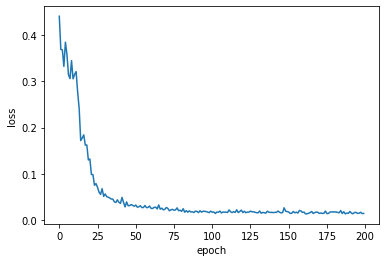

In [15]:
plt.plot(loss_)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'dice coefficient')

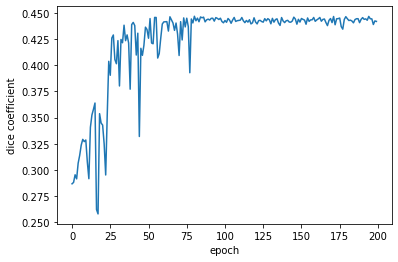

In [16]:
plt.plot(acc_)
plt.xlabel('epoch')
plt.ylabel('dice coefficient')

In [17]:
model_path = '/home/zhangj41/HW/group_proj/Organ_cell_models/unet_epoch190.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

28
torch.Size([100, 3, 128, 128]) torch.Size([100, 1, 128, 128]) torch.Size([100, 1, 128, 128])


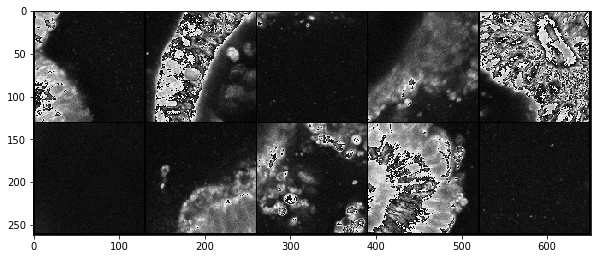

In [18]:
batch_datas, batch_labels = next(iter(DATALOADER_TEST)) 
batch_labels.unsqueeze_(1)

print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
img = make_grid(batch_datas[0:10], nrow=5, padding=2)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()

pred_masks = model(batch_datas)
print(batch_datas.size(), batch_labels.size(), pred_masks.size())

torch.Size([3, 128, 128])


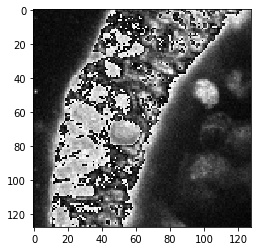

In [19]:
batch_data = batch_datas[1]
print(batch_data.size())
batch_data = batch_data.cpu().data.numpy()
plt.imshow(np.transpose(batch_data, (1,2,0)), cmap='gray', vmin=0, vmax=1)

torch.Size([128, 128])


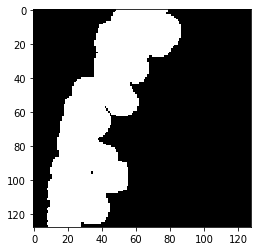

In [20]:
batch_label = batch_labels[1]
batch_label.squeeze_()
print(batch_label.size())
batch_label = batch_label.cpu().data.numpy()
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

torch.Size([128, 128])


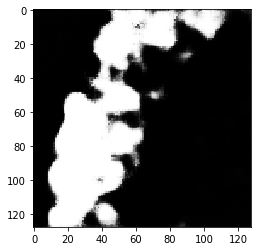

In [21]:
pred_mask = pred_masks[1]
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

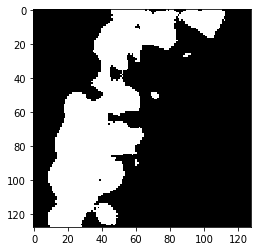

In [22]:
pred_mask[pred_mask>0.5] = 1
pred_mask[pred_mask<=0.5] = 0
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

In [ ]:
batch_label = batch_labels[8]
batch_label.squeeze_()
print(batch_label.size())
batch_label = batch_label.cpu().data.numpy()
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

In [ ]:
pred_mask = pred_masks[8]
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

## Metric

In [16]:
model_path = '/home/zhangj41/HW/group_proj/Organ_cell_models/unet_epoch190.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

solver = CellSeg(unet=model)
iou_avg, precision_avg, dice_coeff_avg = solver.eval_epoch(dataloader=DATALOADER_TEST)

Normal IOU of the dataset: 0.445506
Normal PREC of the dataset: 0.174292
Normal DICE SCORE of the dataset: 0.997408


## Whole image

In [17]:
def img_preprocess(img_dir):
    image = imageio.imread(img_dir).astype("uint8")
    hist, bins = np.histogram(image, bins=256, range=[0,256])
    cum_hist = np.cumsum(hist)
    height, width = image.shape
    norm_cum_hist = cum_hist / (height * width)
    hists_cdf = (norm_cum_hist * 255).astype("uint8")
    # mapping
    img_eq = hists_cdf[image]
    return image
#     plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255)
#     return img_eq

img_transform= transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [18]:
model_path = '/home/zhangj41/HW/group_proj/Organ_cell_models/unet_epoch190.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

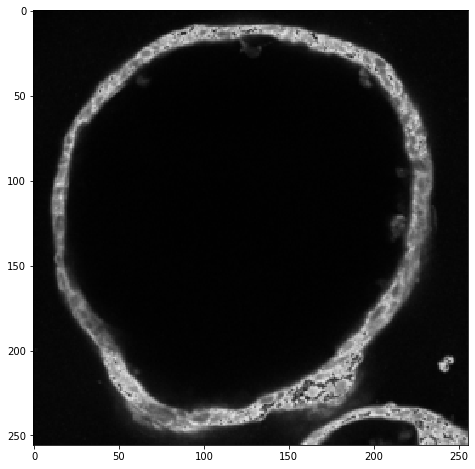

In [19]:
### read the whole image and convert to torch.Tensor
image_loc = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/S1_B6.FCAKPK_Control 1n_photons.tiff'
image_save = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/S1_B6.FCAKPK_Control 1n_photons.png'
cell_img = img_preprocess(img_dir=image_loc)
cell_img = Image.fromarray(cell_img)
cell_img.save(image_save)

imgs = Image.open(image_save).convert('RGB')
imgs = img_transform(imgs)

npimg = imgs.numpy()
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

torch.Size([256, 256])


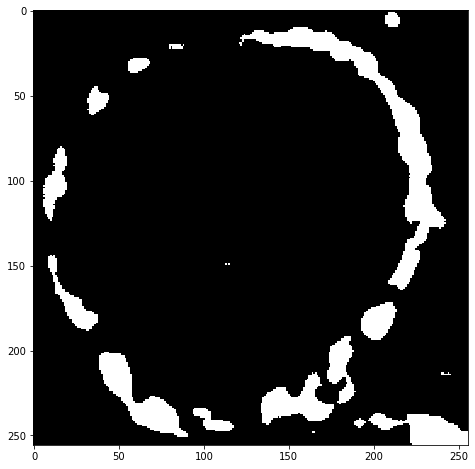

In [20]:
imgs.unsqueeze_(0)
imgs = imgs.cuda()
# imgs.size()

pred_mask = model(imgs)
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
pred_mask[pred_mask>=0.7] = 1
pred_mask[pred_mask<0.7] = 0

plt.figure(figsize=(8, 8))
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

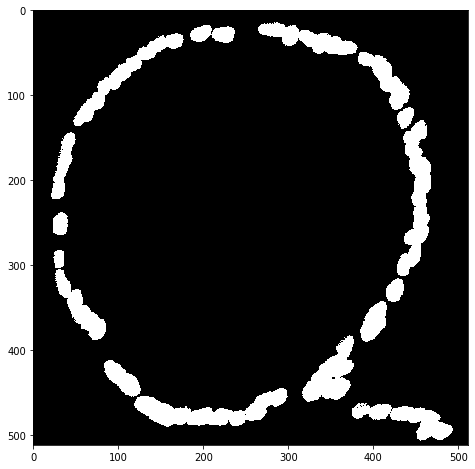

In [21]:
image_loc = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/Masks/Cell_mask_01.tiff'
image = imageio.imread(image_loc).astype("uint8")

image[image>0.5] = 1
image[image<=0.5] = 0

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=0, vmax=1)